In [1]:
import geopandas
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import eust
import intersection
import settings
import nuts
import fadn
import plots

# Load NUTS regions GIS data

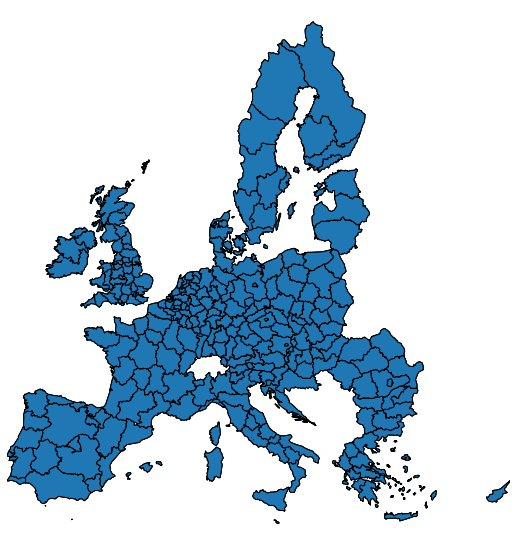

In [2]:
nuts_table = nuts.get_nuts_candidates()
candidate_nuts_regions = nuts_table.index
nuts_geo = (
    geopandas
    .read_file(settings.NUTS_GIS_PATH)
    .set_index('NUTS_ID')
    .reindex(candidate_nuts_regions)
)
ax = nuts_geo.plot(edgecolor='k', legend=True).axes
plots.adj_geoplot(ax)
ax.figure.set_size_inches(10, 10)

# Load FADN regions

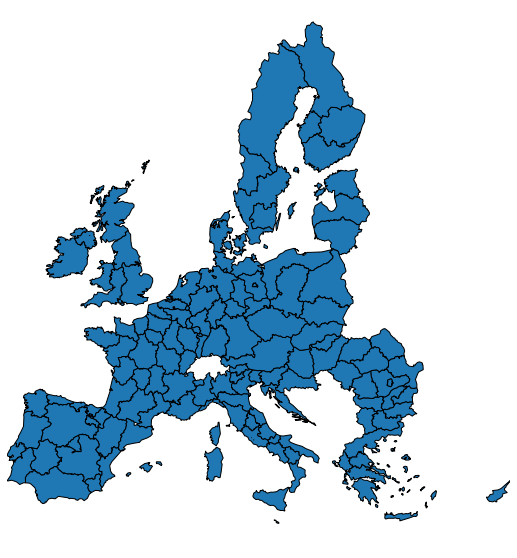

In [3]:
fadn_geo = (
    geopandas
    .read_file(settings.FADN_GIS_PATH)
    .set_index('FADN_2012_')
    [["geometry"]]
)
ax = fadn_geo.plot(edgecolor='k', legend=True).axes
plots.adj_geoplot(ax)
ax.figure.set_size_inches(10, 10)

# Load FADN data

In [4]:
fadn_data = fadn.read_fadn_data('YEAR.COUNTRY.REGION')
fadn_data

SYS02  \
year country_code country_name   region_code region_name                    
2004 BEL          Belgium        341         Vlaanderen             23150   
                                 343         Wallonie               12380   
     CYP          Cyprus         740         Cyprus                 14270   
     CZE          Czech Republic 745         Czech Republic         15930   
     DAN          Denmark        370         Denmark                33850   
...                                                                   ...   
2017 UKI          United Kingdom 412         England - East Region  21680   
                                 413         England - West Region  20700   
                                 421         Wales                  10140   
                                 431         Scotland               13140   
                                 441         Northern Ireland       14880   

                                                                           SYS03  \
year country_code country_name   region_code region_name                           
2004 BEL          Belgium        341         Vlaanderen              500 - <1000   
                                 343         Wallonie                500 - <1000   
     CYP          Cyprus         740         Cyprus                   200 - <500   
     CZE          Czech Republic 745         Czech Republic         1000 - <2000   
     DAN          Denmark        370         Denmark                1000 - <2000   
...                                                                          ...   
2017 UKI          United Kingdom 412         England - East Region   500 - <1000   
                                 413         England - West Region   500 - <1000   
                                 421         Wales                    200 - <500   
                                 431         Scotland                 200 - <500   
                                 441         Northern Ireland         200 - <500   

                                                                       SYS04  \
year country_code country_name   region_code region_name                       
2004 BEL          Belgium        341         Vlaanderen             40.33990   
                                 343         Wallonie               40.33990   
     CYP          Cyprus         740         Cyprus                  0.58192   
     CZE          Czech Republic 745         Czech Republic         31.90567   
     DAN          Denmark        370         Denmark                 7.43990   
...                                                                      ...   
2017 UKI          United Kingdom 412         England - East Region   0.88200   
                                 413         England - West Region   0.88200   
                                 421         Wales                   0.88200   
                                 431         Scotland                0.88200   
                                 441         Northern Ireland        0.88200   

                                                                    SE005  \
year country_code country_name   region_code region_name                    
2004 BEL          Belgium        341         Vlaanderen             206.4   
                                 343         Wallonie               155.1   
     CYP          Cyprus         740         Cyprus                  47.1   
     CZE          Czech Republic 745         Czech Republic         232.3   
     DAN          Denmark        370         Denmark                204.0   
...                                                                   ...   
2017 UKI          United Kingdom 412         England - East Region  329.2   
                                 413         England - West Region  226.7   
                                 421         Wales                  133.6   
                                 431         Scotland               171.7   
        

## Calculate and plot P fertilizer rates for whole UAA

In [5]:
# SE297 = total P2O5 use on farm [100 kg]
# SE025 = total UAA on farm [ha]
fadn_p_qty = (
    fadn_data['SE297']
    .mul(100)  # to kg P2O5
    .mul(31 * 2 / (31 * 2 + 16 * 5)) # to kg P
)
fadn_rates_all = (
    fadn_p_qty
    .div(fadn_data['SE025'])
    .rename('rate')
)
fadn_rates_all

year  country_code  country_name    region_code  region_name          
2004  BEL           Belgium         341          Vlaanderen                    NaN
                                    343          Wallonie                      NaN
      CYP           Cyprus          740          Cyprus                        NaN
      CZE           Czech Republic  745          Czech Republic                NaN
      DAN           Denmark         370          Denmark                       NaN
                                                                            ...   
2017  UKI           United Kingdom  412          England - East Region    9.762165
                                    413          England - West Region    5.664991
                                    421          Wales                    4.819064
                                    431          Scotland                 5.487220
                                    441          Northern Ireland         3.097915
Name: rate, Leng

In [6]:
# Check which years have P rates at all
fadn_rates_all.dropna().index.unique('year')

Int64Index([2014, 2015, 2016, 2017], dtype='int64', name='year')

In [7]:
RATE_PLOT_V_KWS = dict(vmin=0, vmax=30)
def plot_p_rate(d, ax=None, legend=True):
    ax = (
        nuts_geo
        .plot(color='#cccccc', ax=ax)
        .axes
    )
    d.plot(
        'rate',
        cmap='BuPu',
        legend=legend,
        ax=ax,
        **RATE_PLOT_V_KWS
    ).axes
    plots.adj_geoplot(ax)
    return ax

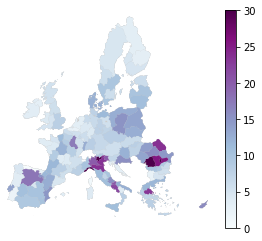

In [8]:
# Take the average value
fadn_rate = fadn_rates_all.groupby('region_code').mean().dropna()
ax = fadn_geo.join(fadn_rate).dropna().pipe(plot_p_rate)

# Load Eurostat area and P rate data

In [9]:
uaa = (
    eust
    .read_table_data('ef_lus_allcrops')
    .value
    .xs('HA', level='unit')
    .xs('UAA', level='crops')
    .xs('TOTAL', level='agrarea')
    .xs(settings.DATA_YEAR, level='time')
    .mul(1e-6) # to Mha
    .pipe(nuts.fill_nuts)
)
uaa

geo
AT      2.72689
AT1     1.09884
AT11    0.18197
AT12    0.90885
AT13    0.00802
         ...   
UKM3    0.79834
UKM5    0.47877
UKM6    2.76356
UKN     1.04614
UKN0    1.04614
Name: value, Length: 428, dtype: float64

# Compare national P rates from different sources

In [10]:
usefert = (
    eust
    .read_table_data('aei_fm_usefert', version='2019-04-30 11:00:00')
    .value
    .xs('P', level='nutrient')
    .xs('T', level='unit')
    .mul(1e-3) # to Gg P
    .pipe(nuts.fill_nuts)
    .rename('usefert')
)
    
manfert = (
    eust
    .read_table_data('aei_fm_manfert', version='2019-03-01 11:00:00')
    .value
    .xs('P', level='nutrient')
    .xs('T', level='unit')
    .mul(1e-3) # to Gg P
    .pipe(nuts.fill_nuts)
    .rename('manfert')
)

eurostat_gnb = (
    eust
    .read_table_data('aei_pr_gnb')
    .value
    .xs('P', level='nutrient')
    .xs('I_FRT_MIN', level='indic_ag')
    .div(1e3) # to Gg P
    .rename('GNB')
)

pd.concat([usefert, manfert, eurostat_gnb], axis=1).xs(settings.DATA_YEAR, level='time').dropna()

,usefert,manfert,GNB
geo,,,
AT,14.234,17.261,17.261
BG,11.656,22.758,11.656
CY,1.945,0.801,0.801
CZ,18.201,17.784,18.201
DE,124.073,124.022,124.073
DK,12.300,13.601,13.601
EE,3.129,4.534,3.129
EL,25.896,25.523,25.523
ES,189.014,186.740,188.928


In [11]:
eurostat_totals = (
    eurostat_gnb
    .xs(settings.DATA_YEAR, level='time')
    .pipe(nuts.filter_nuts_level, 0)
)
eurostat_totals

geo
AT     17.261
BE      5.600
BG     11.656
CY      0.801
CZ     18.201
DE    124.073
DK     13.601
EE      3.129
EL     25.523
ES    188.928
FI     11.184
FR    217.165
HR     12.518
HU     33.504
IE     36.986
IT     74.775
LT     28.396
LU      0.516
LV     10.670
MT      0.031
NL      3.984
PL    168.915
PT     17.289
RO     49.697
SE     11.800
SI      3.886
SK     10.446
UK     84.692
Name: GNB, dtype: float64

# Extract subnational data from Eurostat `aei_fm_usefert` table

## Note that the coverage of subnational data is maximal in the chosen data year

So we do not lose anything by extracting data only from the chosen data year.

In [12]:
usefert_chosen_year = (
    usefert
    .xs(settings.DATA_YEAR, level='time')
    .reindex(candidate_nuts_regions)
    .dropna()
)

usefert_mean_value = (
    usefert
    .groupby('geo')
    .mean()
    .reindex(candidate_nuts_regions)
    .dropna()
)

set(usefert_chosen_year.index) == set(usefert_mean_value.index)

True

## Plot and inspect usefert data on NUTS 0, 1, 2 levels

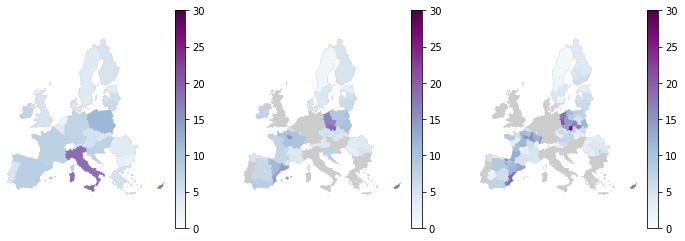

In [13]:
usefert_rate = (
    usefert_chosen_year
    .div(uaa) # Gg / Mha = kg / ha
    .dropna()
    .rename('rate')
)

nuts_levels = [0, 1, 2]
fig, axs = plt.subplots(ncols=len(nuts_levels), figsize=(4 * len(nuts_levels), 4))

for ax, nuts_level in zip(axs, nuts_levels):
    (
        nuts_geo
        .pipe(nuts.filter_nuts_level, nuts_level)
        .join(usefert_rate)
        [['rate', 'geometry']]
        .dropna()
        .pipe(plot_p_rate, ax=ax)
    )
    plots.adj_geoplot(ax)

## Reweight the subnational usefert data to agree with totals

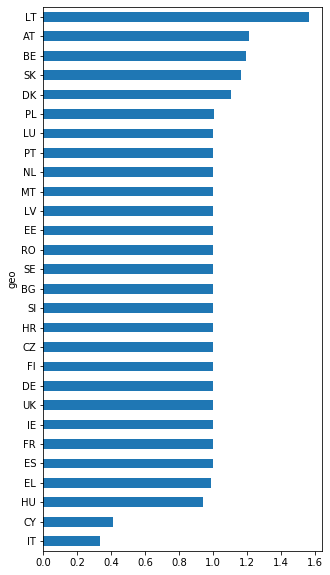

In [14]:
usefert_totals = usefert_chosen_year.pipe(nuts.filter_nuts_level, 0)
usefert_correction_factor = eurostat_totals.div(usefert_totals).rename('factor')
usefert_correction_factor.sort_values().plot.barh(figsize=(5, 10))

In [15]:
usefert_adj = (
    usefert_chosen_year
    .to_frame()
    .join(nuts_table.country_code)
    .join(usefert_correction_factor, on='country_code')
    .eval('usefert * factor')
)
usefert_adj

geo
AT      17.261000
AT11     1.341202
AT12     7.997492
AT2      3.092283
AT21     0.720320
          ...    
SK01     0.647118
SK02     7.036679
SK03     0.929285
SK04     1.834084
UK      84.692000
Length: 174, dtype: float64

In [16]:
eurostat_rate = usefert_chosen_year.div(uaa).rename('rate')
eurostat_rate_adj = usefert_adj.div(uaa).rename('rate')

# Calculate share of each FADN region in each NUTS region

In [17]:
fadn_shares = intersection.get_share(fadn_geo, nuts_geo)
fadn_shares

FADN_2012_  geo 
10          DE      4.304178e-02
            DE6     1.395809e-05
            DE60    1.395809e-05
            DE8     3.571632e-07
            DE80    3.571632e-07
                        ...     
862         HU3     1.554515e-09
            HU33    4.196940e-09
            SI      1.141321e-06
            SI0     1.141321e-06
            SI01    1.903670e-06
Name: share, Length: 1668, dtype: float64

In [18]:
# Sanity check: shares should add up to about 100% in each region
fadn_shares.groupby("geo").sum().describe()

count    393.000000
mean       0.998821
std        0.010248
min        0.861934
25%        0.999997
50%        0.999999
75%        1.000000
max        1.000000
Name: share, dtype: float64

In [19]:
# FADN zone coverage is evidently not 100% everywhere,
# but it is good in almost all the NUTS regions we use here
fadn_shares.groupby('geo').sum()[candidate_nuts_regions].describe()

count    393.000000
mean       0.998821
std        0.010248
min        0.861934
25%        0.999997
50%        0.999999
75%        1.000000
max        1.000000
Name: share, dtype: float64

In [20]:
# Let's inspect the NUTS regions with bad coverage
bad_coverage = (
    fadn_shares
    .groupby('geo')
    .sum()
    [candidate_nuts_regions]
    .sort_values()
    .loc[lambda x: x < 0.95]
)
bad_coverage

geo
EL42    0.861934
FR      0.868241
NL      0.949589
Name: share, dtype: float64

## Check that the regions with bad coverage are no real problems

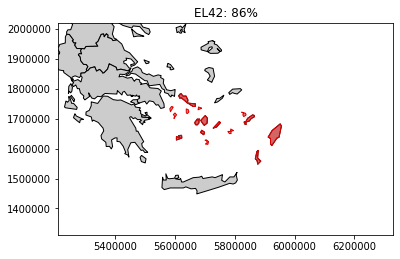

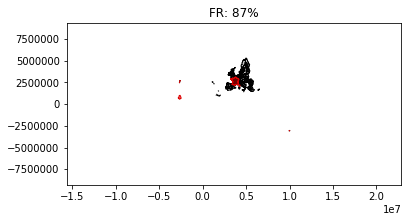

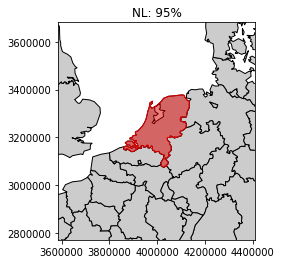

In [21]:
def plot_coverage_case(background, foreground, ax=None):
    ax = background.plot(color='#cccccc', edgecolor='k', ax=ax).axes
    foreground.plot(color='#dd000080', edgecolor='#dd0000', ax=ax)
    xmin, ymin, xmax, ymax = foreground.total_bounds
    dx = xmax - xmin
    dy = ymax - ymin
    ax.set_xlim(xmin-dx, xmax+dx)
    ax.set_ylim(ymin-dy, ymax+dy)
    return ax

for k, v in bad_coverage.items():
    ax = plot_coverage_case(fadn_geo, nuts_geo.loc[[k]])
    ax.set_title(f'{k}: {v:.0%}')

In [22]:
# To deal with the few NUTS regions that are poorly covered,
# calculate weights that by definition add up to 100% in each NUTS region.
# To avoid any mistakes, let's only include the NUTS regions used in this analysis.
fadn_weights = (
    fadn_shares
    .groupby('geo')
    .apply(lambda s: s / s.sum())
    .loc[:, candidate_nuts_regions]
)
fadn_weights.groupby('geo').sum().describe().round(5)

count    393.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: share, dtype: float64

In [23]:
fadn_weights.to_csv(settings.FADN_WEIGHTS_PATH, header=True)

# Calculate FADN yield in NUTS regions using weights

In [24]:
fadn_rate_nuts = (
    fadn_rate
    .rename_axis('FADN_2012_')
    .mul(fadn_weights)
    .groupby('geo')
    .sum()
    .rename('rate')
)
fadn_rate_nuts

geo
AT      5.675903
AT1     5.675905
AT11    5.675928
AT12    5.675901
AT13    5.675897
          ...   
UKM3    5.436145
UKM5    5.436145
UKM6    5.436145
UKN     3.009187
UKN0    3.009187
Name: rate, Length: 393, dtype: float64

# Calculate FADN rates adjusted to agree with national totals

In [25]:
fadn_totals = (
    fadn_rate_nuts
    .mul(uaa)
    .rename('fadn_total')
    .dropna()
    .to_frame()
    .join(nuts_table[['nuts_level', 'country_code']])
    .groupby(['country_code', 'nuts_level'])
    .sum()
)
fadn_totals

fadn_total
country_code nuts_level            
AT           0            15.477562
             1            15.477563
             2            15.477562
BE           0             5.464788
             1             5.388301
...                             ...
SK           1            12.161339
             2            12.161339
UK           0            98.898261
             1            97.452196
             2            97.452196

[84 rows x 1 columns]

In [26]:
totals = (
    fadn_totals
    .join(eurostat_totals.rename('eurostat_total'), on='country_code')
    .dropna()
)
totals

fadn_total  eurostat_total
country_code nuts_level                            
AT           0            15.477562          17.261
             1            15.477563          17.261
             2            15.477562          17.261
BE           0             5.464788           5.600
             1             5.388301           5.600
...                             ...             ...
SK           1            12.161339          10.446
             2            12.161339          10.446
UK           0            98.898261          84.692
             1            97.452196          84.692
             2            97.452196          84.692

[84 rows x 2 columns]

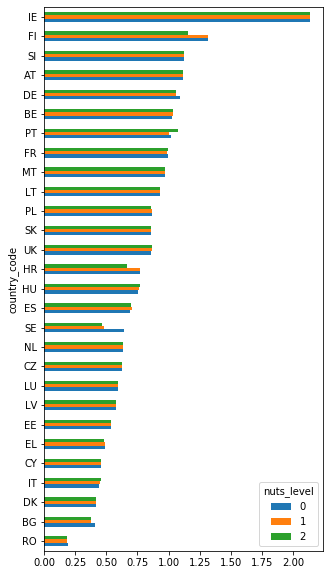

In [27]:
fadn_correction_factor = totals.eval('eurostat_total / fadn_total').rename('factor')
fadn_correction_factor.unstack('nuts_level').sort_values(0).plot.barh(figsize=(5, 10))

In [28]:
fadn_rate_nuts_adj = (
    fadn_rate_nuts
    .to_frame()
    .join(nuts_table)
    .join(fadn_correction_factor, on=['country_code', 'nuts_level'], how='inner')
    .eval('rate * factor')
    .rename('rate')
)
fadn_rate_nuts_adj

geo
AT      6.329922
AT1     6.329924
AT2     6.329920
AT3     6.329920
AT11    6.329950
          ...   
UKM2    4.724347
UKM3    4.724347
UKM5    4.724347
UKM6    4.724347
UKN0    2.615170
Name: rate, Length: 393, dtype: float64

# Inspect the three datasets

/home/rasmus/.local/share/virtualenvs/eu-p-budget-YA21ty_Y/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/rasmus/.local/share/virtualenvs/eu-p-budget-YA21ty_Y/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


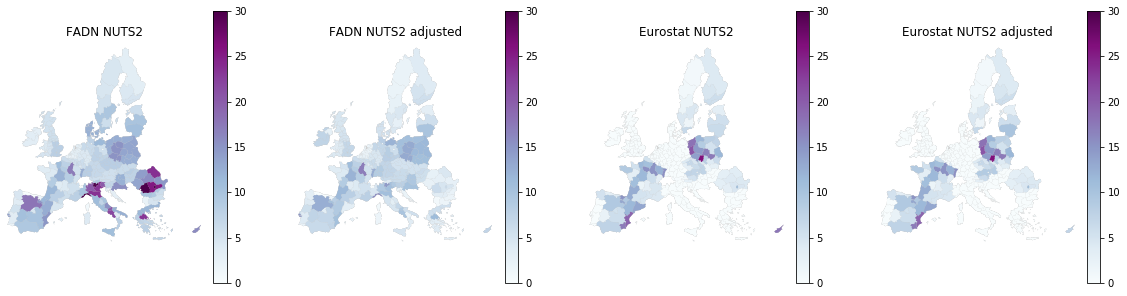

In [29]:
data = {
    'FADN NUTS2': fadn_rate_nuts,
    'FADN NUTS2 adjusted': fadn_rate_nuts_adj,
    'Eurostat NUTS2': eurostat_rate,
    'Eurostat NUTS2 adjusted': eurostat_rate_adj,
}

fig, axs = plt.subplots(ncols=len(data), figsize=(5*len(data), 5))

for (title, s), ax in zip(data.items(), axs):
    plot_p_rate(nuts_geo.pipe(nuts.filter_nuts_level, 2).join(s, how='inner'), ax=ax)
    ax.set_title(title)

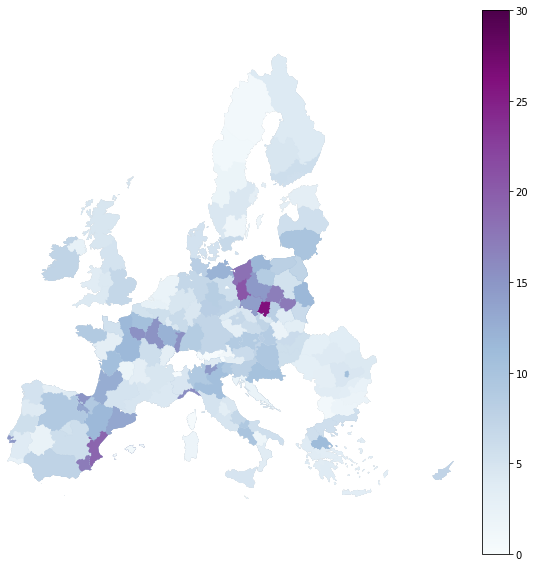

In [30]:
final_rate_estimate = fadn_rate_nuts_adj.reindex(candidate_nuts_regions)
final_rate_estimate.update(eurostat_rate_adj)
ax = plot_p_rate(nuts_geo.join(final_rate_estimate).dropna())
ax.figure.set_size_inches(10, 10)

In [31]:
final_estimate = final_rate_estimate.mul(uaa).rename('mineral')
final_estimate

geo
AT      17.261000
AT1      6.955574
AT11     1.341202
AT12     7.997492
AT13     0.050766
          ...    
UKM3     3.771635
UKM5     2.261876
UKM6    13.056016
UKN      2.735834
UKN0     2.735834
Name: mineral, Length: 428, dtype: float64

In [32]:
final_estimate.to_csv(settings.MINERAL_FERTILIZER_PATH, header=True)